In [ ]:
# ============================================================================
# STEP 1: Importing Required libraries
# ============================================================================

import os
import zipfile
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import shutil
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder 

import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [ ]:

# ============================================================================
# STEP 2: MOUNT GOOGLE DRIVE AND UPLOAD DATASET
# ============================================================================

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import required libraries
import zipfile
import os

# Step 3: Specify paths
zip_path = '/content/drive/MyDrive/Dataset.zip'  # <-- path to your zip in Drive
dataset_raw = '/content/dataset'  # this will be your dataset folder in Colab


Mounted at /content/drive
Dataset extracted to: /content/dataset


In [ ]:
# ===========================================================================
# STEP 3: UNZIP AND ORGANIZE DATASET
# ============================================================================

print("\nExtracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./dataset_raw')

# Find the actual data directory (adjust based on your dataset structure)
# Assuming structure: dataset_raw/real/ and dataset_raw/fake/
# Modify these paths based on your actual dataset structure
raw_data_path = './dataset_raw'

# List directory structure to understand dataset organization
print("\nDataset structure:")
for root, dirs, files in os.walk(raw_data_path):
    level = root.replace(raw_data_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Show first 3 files
        print(f'{subindent}{file}')
    if len(files) > 3:
        print(f'{subindent}... and {len(files)-3} more files')


Extracting dataset...

Dataset structure:
dataset_raw/
  real_and_fake_face_detection/
    real_and_fake_face/
      training_real/
        real_00212.jpg
        real_01047.jpg
        real_00007.jpg
        ... and 1078 more files
      training_fake/
        mid_310_0111.jpg
        easy_5_1100.jpg
        mid_39_1111.jpg
        ... and 957 more files
  real_and_fake_face/
    training_real/
      real_00212.jpg
      real_01047.jpg
      real_00007.jpg
      ... and 1078 more files
    training_fake/
      mid_310_0111.jpg
      easy_5_1100.jpg
      mid_39_1111.jpg
      ... and 957 more files


In [ ]:

# ==================================================================================
# step 4:  Organize Dataset into Train/Validation/Test Splits with Balanced Classes
# ===================================================================================

def organize_dataset(raw_path, output_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Organize dataset into train/val/test splits with balanced classes
    """
    # Create output directories
    splits = ['train', 'val', 'test']
    classes = ['real', 'fake']

    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_path, split, cls), exist_ok=True)

    # Collect all image paths
    # Adjust these paths based on your dataset structure
    # Correcting paths based on the observed extraction structure
    real_path = os.path.join(raw_path, 'real_and_fake_face_detection', 'real_and_fake_face', 'training_real')
    fake_path = os.path.join(raw_path, 'real_and_fake_face_detection', 'real_and_fake_face', 'training_fake')


    real_images = [os.path.join(real_path, f) for f in os.listdir(real_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    fake_images = [os.path.join(fake_path, f) for f in os.listdir(fake_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Found {len(real_images)} real images and {len(fake_images)} fake images")

    def split_and_copy(images, class_name):
        # Shuffle images
        random.shuffle(images)

        # Calculate split indices
        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        # Split data
        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train + n_val]
        test_imgs = images[n_train + n_val:]

        # Copy files
        for img_path in tqdm(train_imgs, desc=f"Copying {class_name} train"):
            dest = os.path.join(output_path, 'train', class_name, os.path.basename(img_path))
            shutil.copy2(img_path, dest)

        for img_path in tqdm(val_imgs, desc=f"Copying {class_name} val"):
            dest = os.path.join(output_path, 'val', class_name, os.path.basename(img_path))
            shutil.copy2(img_path, dest)

        for img_path in tqdm(test_imgs, desc=f"Copying {class_name} test"):
            dest = os.path.join(output_path, 'test', class_name, os.path.basename(img_path))
            shutil.copy2(img_path, dest)

        return len(train_imgs), len(val_imgs), len(test_imgs)

    # Process both classes
    real_counts = split_and_copy(real_images, 'real')
    fake_counts = split_and_copy(fake_images, 'fake')

    print("\nDataset split complete!")
    print(f"Real - Train: {real_counts[0]}, Val: {real_counts[1]}, Test: {real_counts[2]}")
    print(f"Fake - Train: {fake_counts[0]}, Val: {fake_counts[1]}, Test: {fake_counts[2]}")

    return real_counts, fake_counts

# Define the raw data path
# Based on the extraction in cell U6PUN4_n9l9R, the raw data is under './dataset_raw'
raw_data_path = './dataset_raw'


# Organize dataset
organized_path = './dataset_organized'
real_counts, fake_counts = organize_dataset(raw_data_path, organized_path)

Found 1081 real images and 960 fake images


Copying fake test: 100%|██████████| 144/144 [00:00<00:00, 4056.39it/s]


Dataset split complete!
Real - Train: 756, Val: 162, Test: 163
Fake - Train: 672, Val: 144, Test: 144


In [ ]:
# ==================================================================================
# step 5: Define Image Transformations, Create Datasets, and Initialize DataLoaders
# ==================================================================================

IMG_SIZE = 224

# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation and test transforms (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ImageFolder(os.path.join(organized_path, 'train'), transform=train_transforms)
val_dataset = ImageFolder(os.path.join(organized_path, 'val'), transform=val_test_transforms)
test_dataset = ImageFolder(os.path.join(organized_path, 'test'), transform=val_test_transforms)

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")
print(f"Class to index: {train_dataset.class_to_idx}")

# Create data loaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)



Dataset sizes:
Train: 1860
Validation: 565
Test: 567
Classes: ['fake', 'real']
Class to index: {'fake': 0, 'real': 1}


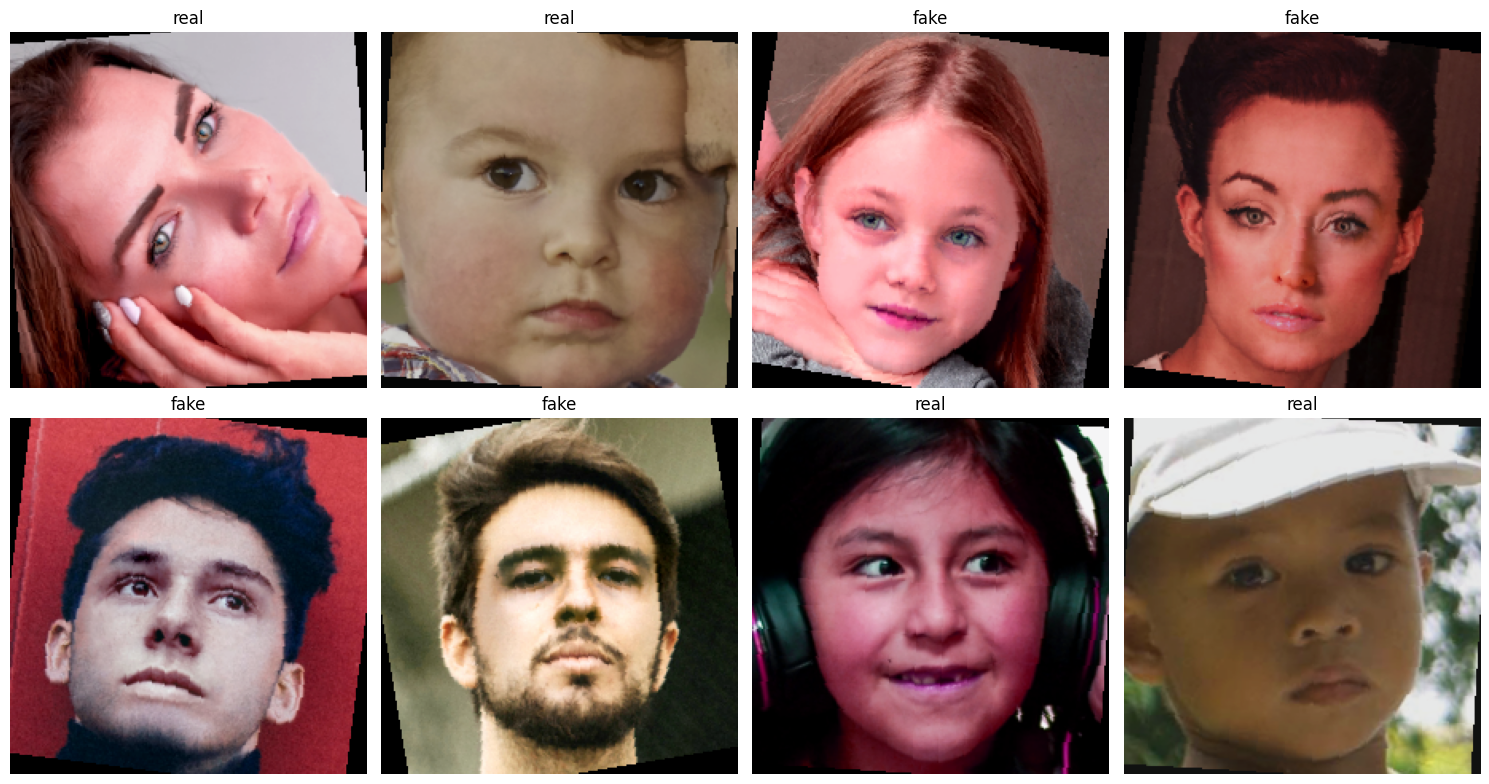

In [ ]:
# ==================================================================================
# step 6: Visualize Sample Images from Training Set
# ==================================================================================

def imshow(img, title=None):
    """Display tensor image"""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Display sample images
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(15, 8))
for idx in range(min(8, len(images))):
    plt.subplot(2, 4, idx + 1)
    imshow(images[idx], title=train_dataset.classes[labels[idx]])
plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()




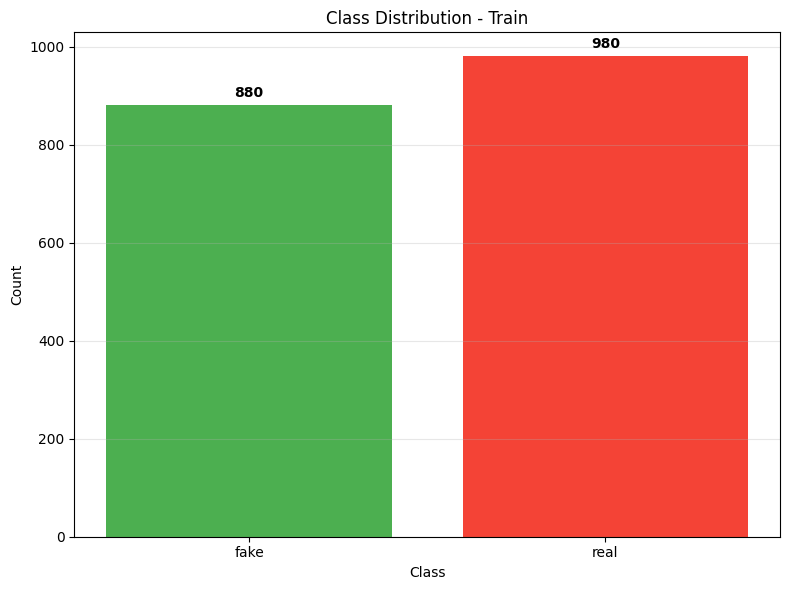

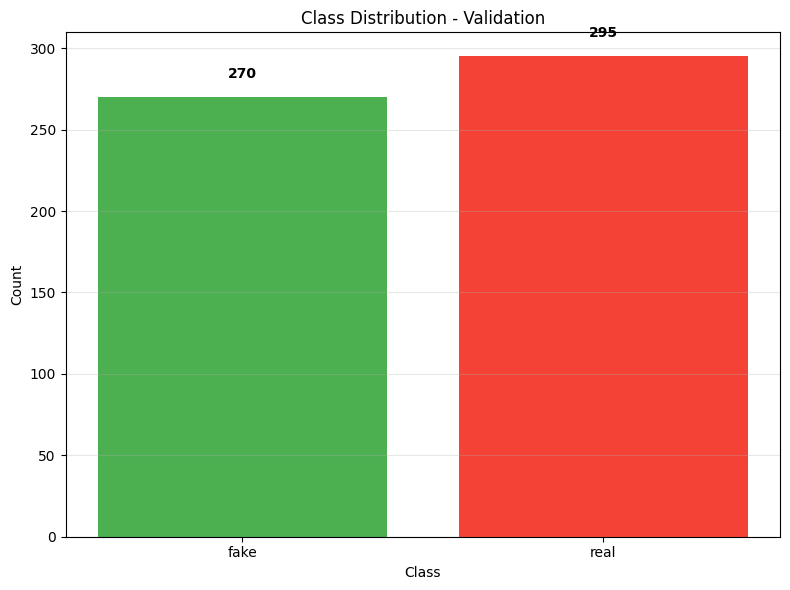

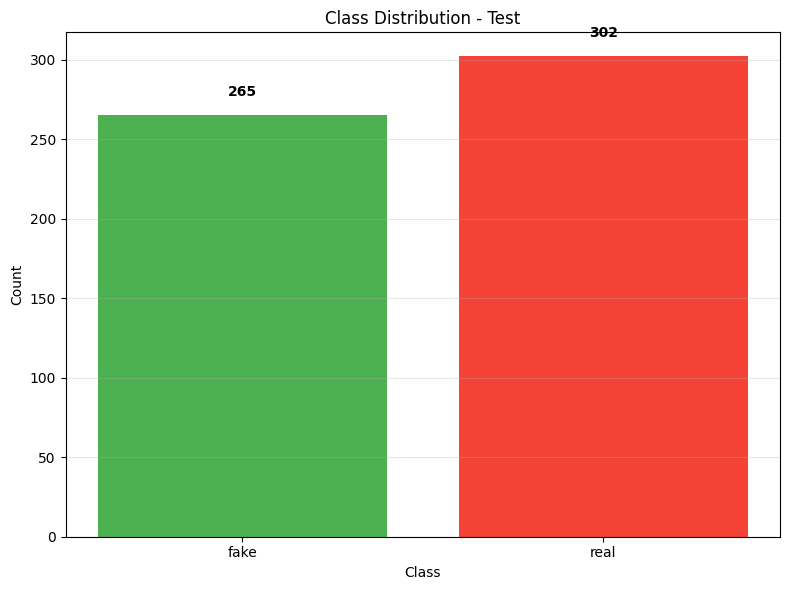

In [ ]:
# ==================================================================================
# step 7: Plot Class Distribution for Train, Validation, and Test Sets
# ==================================================================================

def plot_class_distribution(dataset, split_name):
    labels = [label for _, label in dataset]
    unique, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(8, 6))
    plt.bar([dataset.classes[i] for i in unique], counts, color=['#4CAF50', '#F44336'])
    plt.title(f'Class Distribution - {split_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.3)
    for i, v in enumerate(counts):
        plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'class_distribution_{split_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_class_distribution(train_dataset, 'Train')
plot_class_distribution(val_dataset, 'Validation')
plot_class_distribution(test_dataset, 'Test')


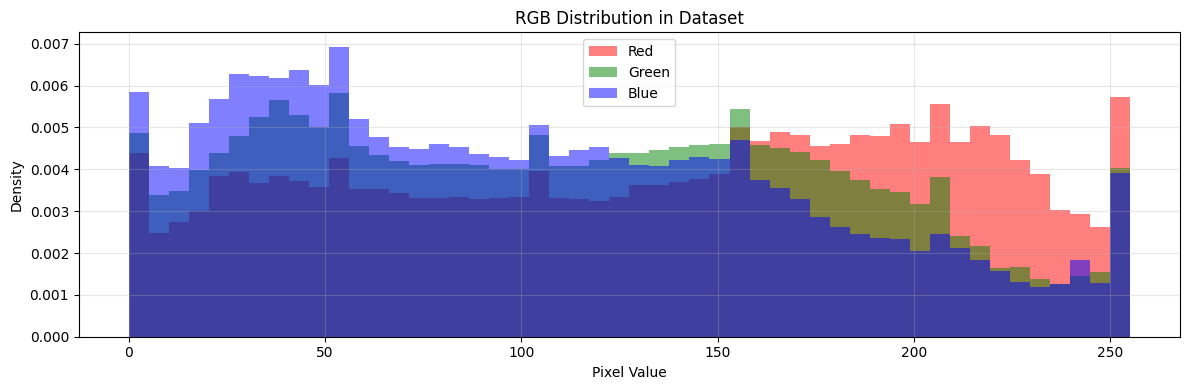

In [ ]:
# ==================================================================================
# step 8: Plot RGB Color Histograms of Sample Images from Training Set
# ==================================================================================

def plot_color_histogram(dataset, num_samples=100):
    """Plot RGB histograms of sample images"""
    r_vals, g_vals, b_vals = [], [], []

    for i in range(min(num_samples, len(dataset))):
        img_path = dataset.imgs[i][0]
        img = Image.open(img_path).convert('RGB')
        img = img.resize((224, 224))
        img_array = np.array(img)

        r_vals.extend(img_array[:,:,0].flatten())
        g_vals.extend(img_array[:,:,1].flatten())
        b_vals.extend(img_array[:,:,2].flatten())

    plt.figure(figsize=(12, 4))
    plt.hist(r_vals, bins=50, alpha=0.5, label='Red', color='red', density=True)
    plt.hist(g_vals, bins=50, alpha=0.5, label='Green', color='green', density=True)
    plt.hist(b_vals, bins=50, alpha=0.5, label='Blue', color='blue', density=True)
    plt.xlabel('Pixel Value')
    plt.ylabel('Density')
    plt.title('RGB Distribution in Dataset')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('color_histogram.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_color_histogram(train_dataset)

In [ ]:
# ==================================================================================
# step 9: Define and Initialize Vision Transformer (ViT) Model for Deepfake Detection
# ==================================================================================

class DeepfakeViT(nn.Module):
    def __init__(self, model_name='vit_tiny_patch16_224', pretrained=True, num_classes=2, dropout=0.2):
        super(DeepfakeViT, self).__init__()

        # Load pretrained ViT
        self.vit = timm.create_model(model_name, pretrained=pretrained)

        # Get the number of features from the model
        if hasattr(self.vit, 'head'):
            n_features = self.vit.head.in_features
            self.vit.head = nn.Identity()  # Remove original head
        elif hasattr(self.vit, 'fc'):
            n_features = self.vit.fc.in_features
            self.vit.fc = nn.Identity()
        else:
            n_features = self.vit.num_features

        # Custom classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(n_features, 512),
            nn.GELU(),
            nn.Dropout(dropout / 2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.vit(x)
        return self.classifier(features)

# Initialize model
model = DeepfakeViT(model_name='vit_tiny_patch16_224', pretrained=True, num_classes=2, dropout=0.2)
model = model.to(device)

print(f"\nModel created successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]


Model created successfully!
Total parameters: 5,624,258
Trainable parameters: 5,624,258


In [ ]:
# ==================================================================================
# step 10: Define Loss Function, Optimizer, Scheduler, and Training Configuration
# ==================================================================================

criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# Training configuration
NUM_EPOCHS = 20
EARLY_STOPPING_PATIENCE = 10
BEST_MODEL_PATH = 'best_deepfake_vit.pth'


STARTING TRAINING


Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.06it/s, loss=0.661, acc=62.1]



Train Loss: 0.7375 | Train Acc: 53.06%
Val Loss: 0.6608 | Val Acc: 62.12%
Learning Rate: 0.000099
✓ Model saved! (Val Loss: 0.6608)

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:06<00:00,  2.86it/s, loss=0.667, acc=63.4]



Train Loss: 0.6521 | Train Acc: 61.02%
Val Loss: 0.6669 | Val Acc: 63.36%
Learning Rate: 0.000098
✗ No improvement (1/10)

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.49it/s, loss=0.511, acc=74.9]



Train Loss: 0.6110 | Train Acc: 66.72%
Val Loss: 0.5115 | Val Acc: 74.87%
Learning Rate: 0.000095
✓ Model saved! (Val Loss: 0.5115)

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:06<00:00,  2.63it/s, loss=0.483, acc=80.5]



Train Loss: 0.5519 | Train Acc: 72.20%
Val Loss: 0.4826 | Val Acc: 80.53%
Learning Rate: 0.000091
✓ Model saved! (Val Loss: 0.4826)

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s, loss=0.426, acc=80.9]



Train Loss: 0.4643 | Train Acc: 78.60%
Val Loss: 0.4264 | Val Acc: 80.88%
Learning Rate: 0.000086
✓ Model saved! (Val Loss: 0.4264)

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.51it/s, loss=0.374, acc=83.5]



Train Loss: 0.4248 | Train Acc: 80.16%
Val Loss: 0.3739 | Val Acc: 83.54%
Learning Rate: 0.000080
✓ Model saved! (Val Loss: 0.3739)

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:06<00:00,  2.63it/s, loss=0.32, acc=86.4]



Train Loss: 0.3459 | Train Acc: 84.57%
Val Loss: 0.3201 | Val Acc: 86.37%
Learning Rate: 0.000073
✓ Model saved! (Val Loss: 0.3201)

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s, loss=0.305, acc=89.2]



Train Loss: 0.3081 | Train Acc: 86.51%
Val Loss: 0.3050 | Val Acc: 89.20%
Learning Rate: 0.000066
✓ Model saved! (Val Loss: 0.3050)

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:06<00:00,  2.90it/s, loss=0.241, acc=91.5]



Train Loss: 0.2642 | Train Acc: 88.92%
Val Loss: 0.2408 | Val Acc: 91.50%
Learning Rate: 0.000058
✓ Model saved! (Val Loss: 0.2408)

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.16it/s, loss=0.42, acc=85.7]



Train Loss: 0.2523 | Train Acc: 89.46%
Val Loss: 0.4198 | Val Acc: 85.66%
Learning Rate: 0.000051
✗ No improvement (1/10)

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.57it/s, loss=0.222, acc=93.1]



Train Loss: 0.1998 | Train Acc: 92.53%
Val Loss: 0.2220 | Val Acc: 93.10%
Learning Rate: 0.000043
✓ Model saved! (Val Loss: 0.2220)

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:06<00:00,  2.60it/s, loss=0.23, acc=92.7]



Train Loss: 0.1652 | Train Acc: 93.71%
Val Loss: 0.2298 | Val Acc: 92.74%
Learning Rate: 0.000035
✗ No improvement (1/10)

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.04it/s, loss=0.202, acc=93.5]



Train Loss: 0.1584 | Train Acc: 93.60%
Val Loss: 0.2018 | Val Acc: 93.45%
Learning Rate: 0.000028
✓ Model saved! (Val Loss: 0.2018)

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.46it/s, loss=0.181, acc=94.7]



Train Loss: 0.1117 | Train Acc: 95.54%
Val Loss: 0.1810 | Val Acc: 94.69%
Learning Rate: 0.000021
✓ Model saved! (Val Loss: 0.1810)

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:06<00:00,  2.69it/s, loss=0.19, acc=94.7]



Train Loss: 0.0970 | Train Acc: 96.61%
Val Loss: 0.1902 | Val Acc: 94.69%
Learning Rate: 0.000015
✗ No improvement (1/10)

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.33it/s, loss=0.179, acc=94.3]



Train Loss: 0.0773 | Train Acc: 97.15%
Val Loss: 0.1789 | Val Acc: 94.34%
Learning Rate: 0.000010
✓ Model saved! (Val Loss: 0.1789)

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.38it/s, loss=0.183, acc=95.2]



Train Loss: 0.0718 | Train Acc: 97.15%
Val Loss: 0.1825 | Val Acc: 95.22%
Learning Rate: 0.000006
✗ No improvement (1/10)

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:06<00:00,  2.65it/s, loss=0.172, acc=94.7]



Train Loss: 0.0553 | Train Acc: 97.90%
Val Loss: 0.1721 | Val Acc: 94.69%
Learning Rate: 0.000003
✓ Model saved! (Val Loss: 0.1721)

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.57it/s, loss=0.177, acc=94.5]



Train Loss: 0.0412 | Train Acc: 98.33%
Val Loss: 0.1771 | Val Acc: 94.51%
Learning Rate: 0.000002
✗ No improvement (1/10)

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.02it/s, loss=0.175, acc=94.7]



Train Loss: 0.0531 | Train Acc: 98.12%
Val Loss: 0.1745 | Val Acc: 94.69%
Learning Rate: 0.000001
✗ No improvement (2/10)

TRAINING COMPLETE



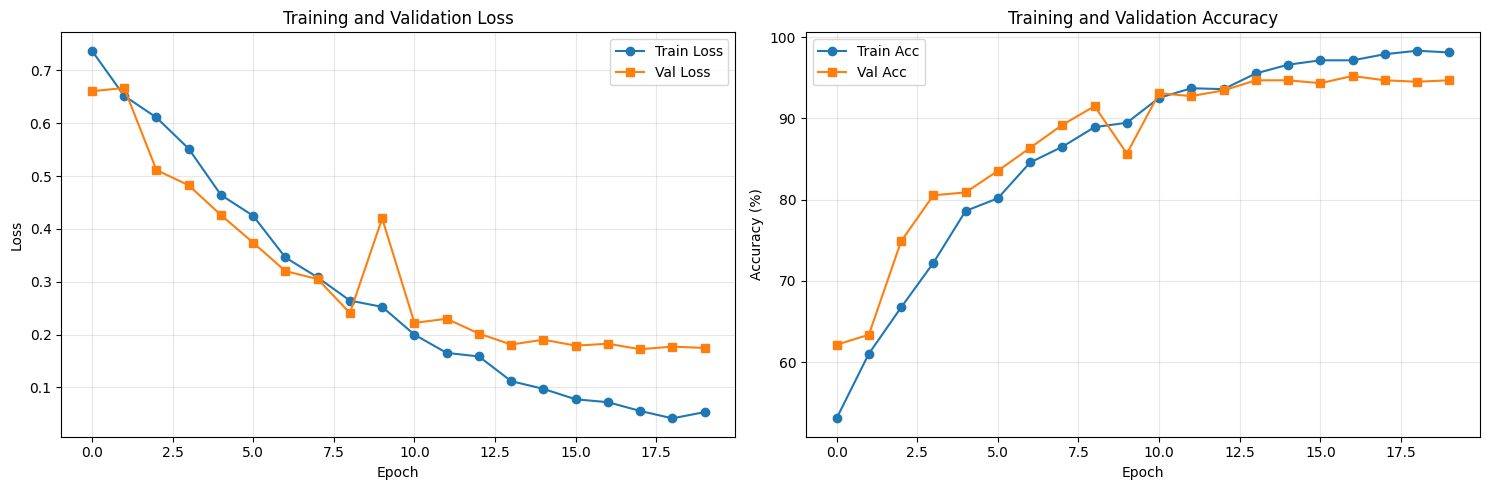

In [ ]:
# ==================================================================================
# step 11: Train and Validate the Deepfake ViT Model with Early Stopping
# ==================================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc='Training')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        progress_bar.set_postfix({'loss': running_loss/len(progress_bar),
                                  'acc': 100.*correct/total})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(loader, desc='Validation')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'loss': running_loss/len(progress_bar),
                                      'acc': 100.*correct/total})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
patience_counter = 0

print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50 + "\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step()

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'history': history
        }, BEST_MODEL_PATH)
        print(f"✓ Model saved! (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"✗ No improvement ({patience_counter}/{EARLY_STOPPING_PATIENCE})")

    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs!")
        break

print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50 + "\n")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()



Loaded best model from epoch 18
Best validation loss: 0.1721
Best validation accuracy: 94.69%


Testing: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s]



TEST SET EVALUATION
Accuracy: 94.00%
F1-Score: 0.9399
ROC-AUC: 0.9847

Classification Report:
              precision    recall  f1-score   support

        fake       0.95      0.92      0.93       265
        real       0.93      0.96      0.94       302

    accuracy                           0.94       567
   macro avg       0.94      0.94      0.94       567
weighted avg       0.94      0.94      0.94       567



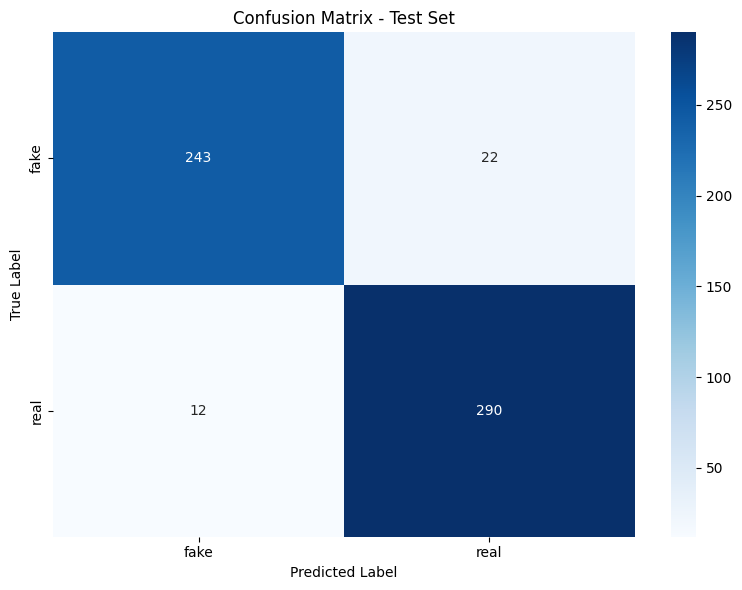

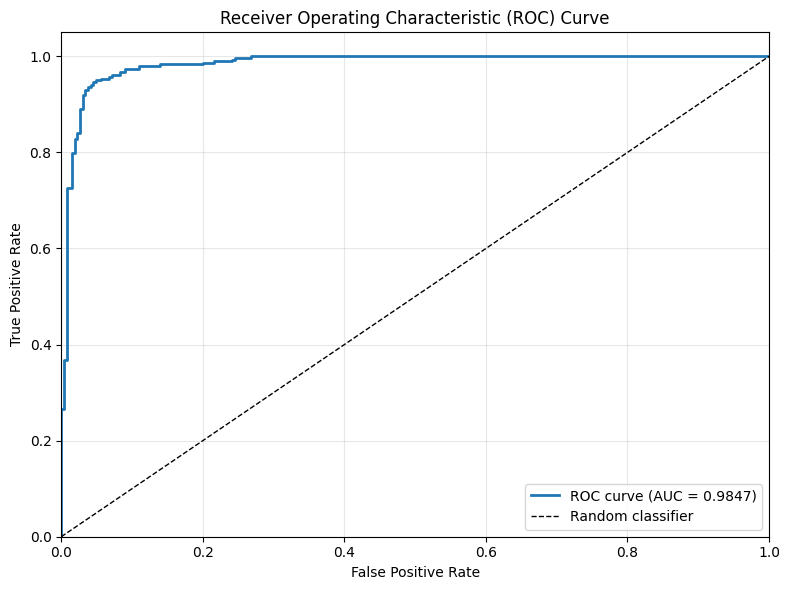

In [ ]:
# ==================================================================================
# step 12: Load Best Model and Evaluate on Test Set
# ==================================================================================

checkpoint = torch.load(BEST_MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best validation loss: {checkpoint['val_loss']:.4f}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of fake class

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
roc_auc = roc_auc_score(all_labels, all_probs)

print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# ==================================================================================
# step 13: Save Final Model and Metadata to Google Drive
# ==================================================================================

drive_model_path = '/content/drive/MyDrive/deepfake_vit_final.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'class_to_idx': train_dataset.class_to_idx,
    'idx_to_class': {v: k for k, v in train_dataset.class_to_idx.items()},
    'test_accuracy': accuracy,
    'test_f1': f1,
    'test_roc_auc': roc_auc
}, drive_model_path)

print(f"\n✓ Final model saved to Google Drive: {drive_model_path}")


✓ Final model saved to Google Drive: /content/drive/MyDrive/deepfake_vit_final.pth



INFERENCE EXAMPLES

Image 1:
  True: fake
  Predicted: fake (99.99%)
  Probabilities: Real=99.99%, Fake=0.01%

Image 2:
  True: fake
  Predicted: fake (99.92%)
  Probabilities: Real=99.92%, Fake=0.08%

Image 3:
  True: fake
  Predicted: real (96.28%)
  Probabilities: Real=3.72%, Fake=96.28%

Image 4:
  True: fake
  Predicted: real (65.70%)
  Probabilities: Real=34.30%, Fake=65.70%

Image 5:
  True: fake
  Predicted: fake (98.12%)
  Probabilities: Real=98.12%, Fake=1.88%



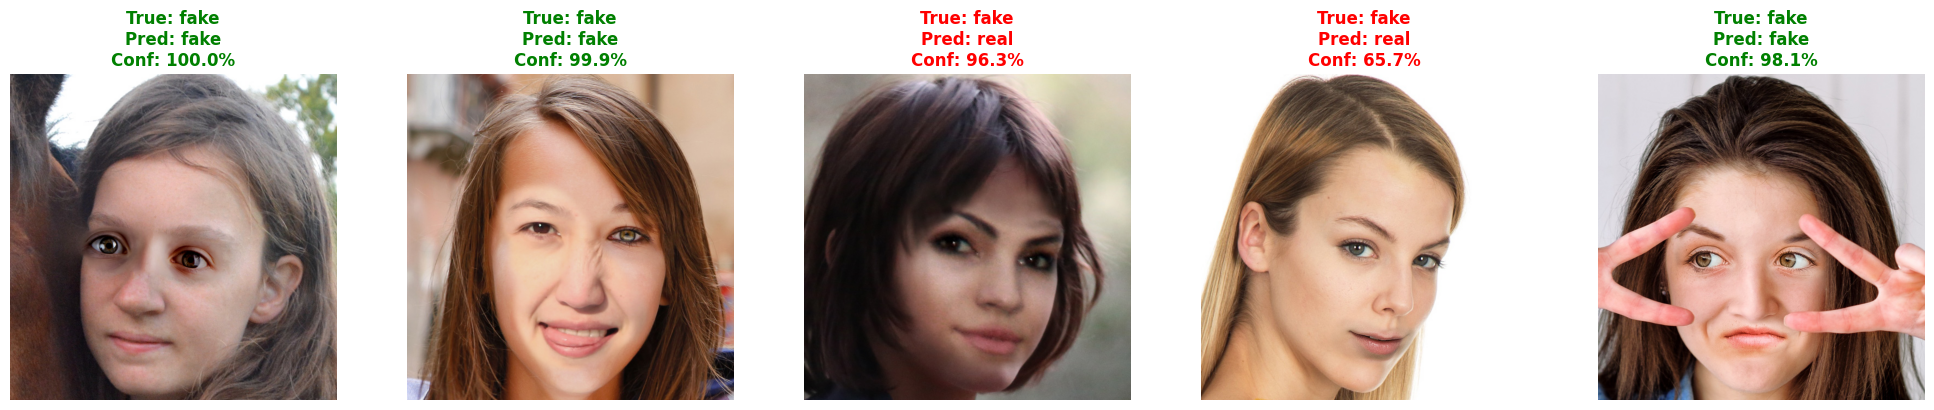


NOTEBOOK COMPLETE!

Your trained model has been saved to Google Drive.
Use predict_custom_image() to test on new images!

Files saved:
  - Model: /content/drive/MyDrive/deepfake_vit_final.pth
  - Best checkpoint: model.pth
  - Visualizations: sample_images.png, confusion_matrix.png, roc_curve.png, etc.


In [ ]:
# ==================================================================================
# step 14: Define Inference Functions for Test and Custom Images
# ==================================================================================

def predict_image(model, image_path, transform, device, class_names):
    """
    Predict whether a single image is real or fake
    """
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, predicted = probs.max(1)

    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item() * 100

    return predicted_class, confidence_score, probs[0].cpu().numpy()

# Example: Predict on test images
print("\n" + "="*50)
print("INFERENCE EXAMPLES")
print("="*50 + "\n")

# Get some test images
test_images = test_dataset.imgs[:5]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, (img_path, true_label) in enumerate(test_images):
    pred_class, confidence, probs = predict_image(
        model, img_path, val_test_transforms, device, train_dataset.classes
    )

    # Display image
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].axis('off')

    true_class = train_dataset.classes[true_label]
    color = 'green' if pred_class == true_class else 'red'
    axes[idx].set_title(
        f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%',
        color=color, fontweight='bold'
    )

    print(f"Image {idx+1}:")
    print(f"  True: {true_class}")
    print(f"  Predicted: {pred_class} ({confidence:.2f}%)")
    print(f"  Probabilities: Real={probs[0]*100:.2f}%, Fake={probs[1]*100:.2f}%")
    print()

plt.tight_layout()
plt.savefig('inference_examples.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# INFERENCE FUNCTION FOR CUSTOM IMAGES
# ============================================================================

def predict_custom_image(model_path, image_path):
    """
    Load model and predict on a custom image
    Usage: predict_custom_image('/path/to/model.pth', '/path/to/image.jpg')
    """
    # Load model
    checkpoint = torch.load(model_path, map_location=device)
    model = DeepfakeViT(model_name='vit_tiny_patch16_224', pretrained=False, num_classes=2)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    # Get class names
    idx_to_class = checkpoint['idx_to_class']
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

    # Predict
    pred_class, confidence, probs = predict_image(
        model, image_path, val_test_transforms, device, class_names
    )

    # Display result
    img = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {pred_class.upper()}\nConfidence: {confidence:.2f}%',
              fontsize=16, fontweight='bold',
              color='green' if pred_class == 'real' else 'red')
    plt.tight_layout()
    plt.show()

    print(f"Prediction: {pred_class}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Probabilities: Real={probs[0]*100:.2f}%, Fake={probs[1]*100:.2f}%")

    return pred_class, confidence, probs

# Example usage (uncomment to use):
# predict_custom_image(drive_model_path, '/path/to/your/image.jpg')

print("\n" + "="*50)
print("NOTEBOOK COMPLETE!")
print("="*50)
print("\nYour trained model has been saved to Google Drive.")
print("Use predict_custom_image() to test on new images!")
print("\nFiles saved:")
print(f"  - Model: {drive_model_path}")
print(f"  - Best checkpoint: {BEST_MODEL_PATH}")
print("  - Visualizations: sample_images.png, confusion_matrix.png, roc_curve.png, etc.")

In [ ]:
# ==================================================================================
# step 15: Upload and Predict on Custom Images in Google Colab
# ==================================================================================

# ---- Load model ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Update the model path to the saved best checkpoint
model_path = "deepfake_vit_final.pth"
# Ensure the working directory is where the model was saved if not already
# os.chdir('/content/deepfake_detection') # Uncomment if you changed directories after saving

# Load the checkpoint dictionary
checkpoint = torch.load(model_path, map_location=device)

# Initialize the model architecture (make sure the DeepfakeViT class is defined)
# Assuming DeepfakeViT class is defined in a previous cell and accessible
# IMPORTANT: Ensure the cell defining the 'DeepfakeViT' class (cell 2mWPjDTE78E5) has been run before this cell.
model = DeepfakeViT(model_name='vit_tiny_patch16_224', pretrained=False, num_classes=2) # pretrained=False since we are loading a trained model

# Load the state dict from the checkpoint into the model
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

# ---- Define transforms (same as validation/testing) ----
# Use the same normalization values as used during training (from cell YpK2pHwK7xh9)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ---- Prediction function ----
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1) # Get probabilities
        confidence, predicted = torch.max(probs, 1) # Get predicted class and confidence

    # Get class names from the checkpoint if available, otherwise define manually
    if 'idx_to_class' in checkpoint:
         idx_to_class = checkpoint['idx_to_class']
         classes = [idx_to_class[i] for i in range(len(idx_to_class))]
    elif 'class_to_idx' in checkpoint:
         class_to_idx = checkpoint['class_to_idx']
         classes = [k for k, v in sorted(class_to_idx.items(), key=lambda item: item[1])]
    else:
        # Default class names if not saved in checkpoint - ensure this matches your training
        classes = ["fake", "real"]


    predicted_class_name = classes[predicted.item()]
    confidence_score = confidence.item() * 100

    return predicted_class_name, confidence_score

# ---- Upload and Test ----
print("Please upload the image(s) you want to predict on.")
uploaded = files.upload()
for filename in uploaded.keys():
    prediction_class, prediction_confidence = predict_image(filename)
    print(f"Image: {filename} -> Prediction: {prediction_class} (Confidence: {prediction_confidence:.2f}%)")

Please upload the image(s) you want to predict on.


Saving WhatsApp Image 2025-10-04 at 11.59.45_77b1385b.jpg to WhatsApp Image 2025-10-04 at 11.59.45_77b1385b.jpg
Image: WhatsApp Image 2025-10-04 at 11.59.45_77b1385b.jpg -> Prediction: fake (Confidence: 99.98%)
